# Project Statement

The goal here is to train a model to automatically detect negative reviews. The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. Use a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
print(df_reviews.duplicated().sum())
df_reviews.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1

In [6]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [7]:
df_reviews.dropna()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


## EDA

Let's check the number of movies and reviews over years.

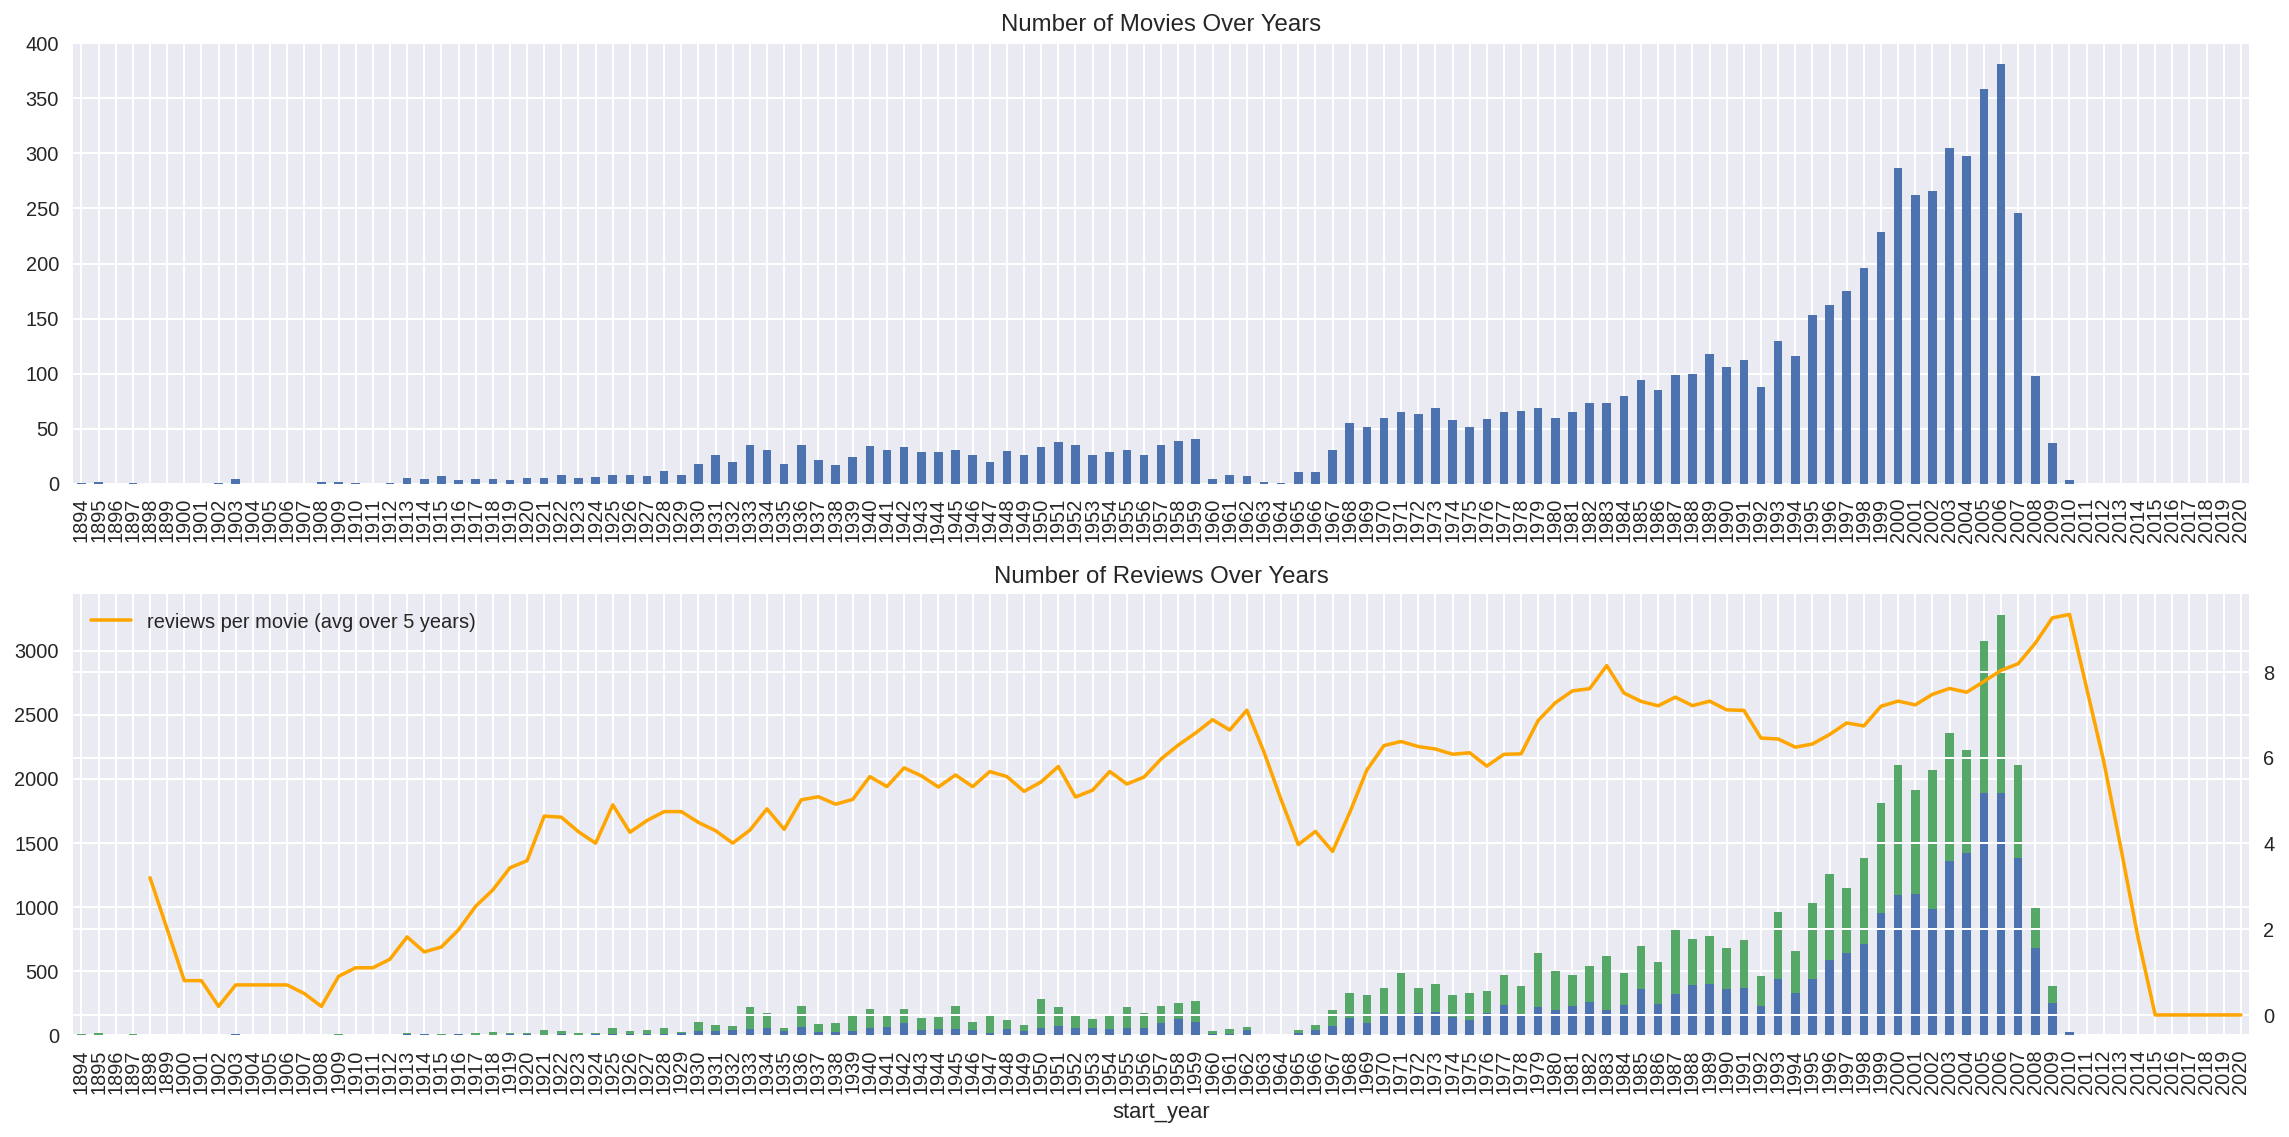

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

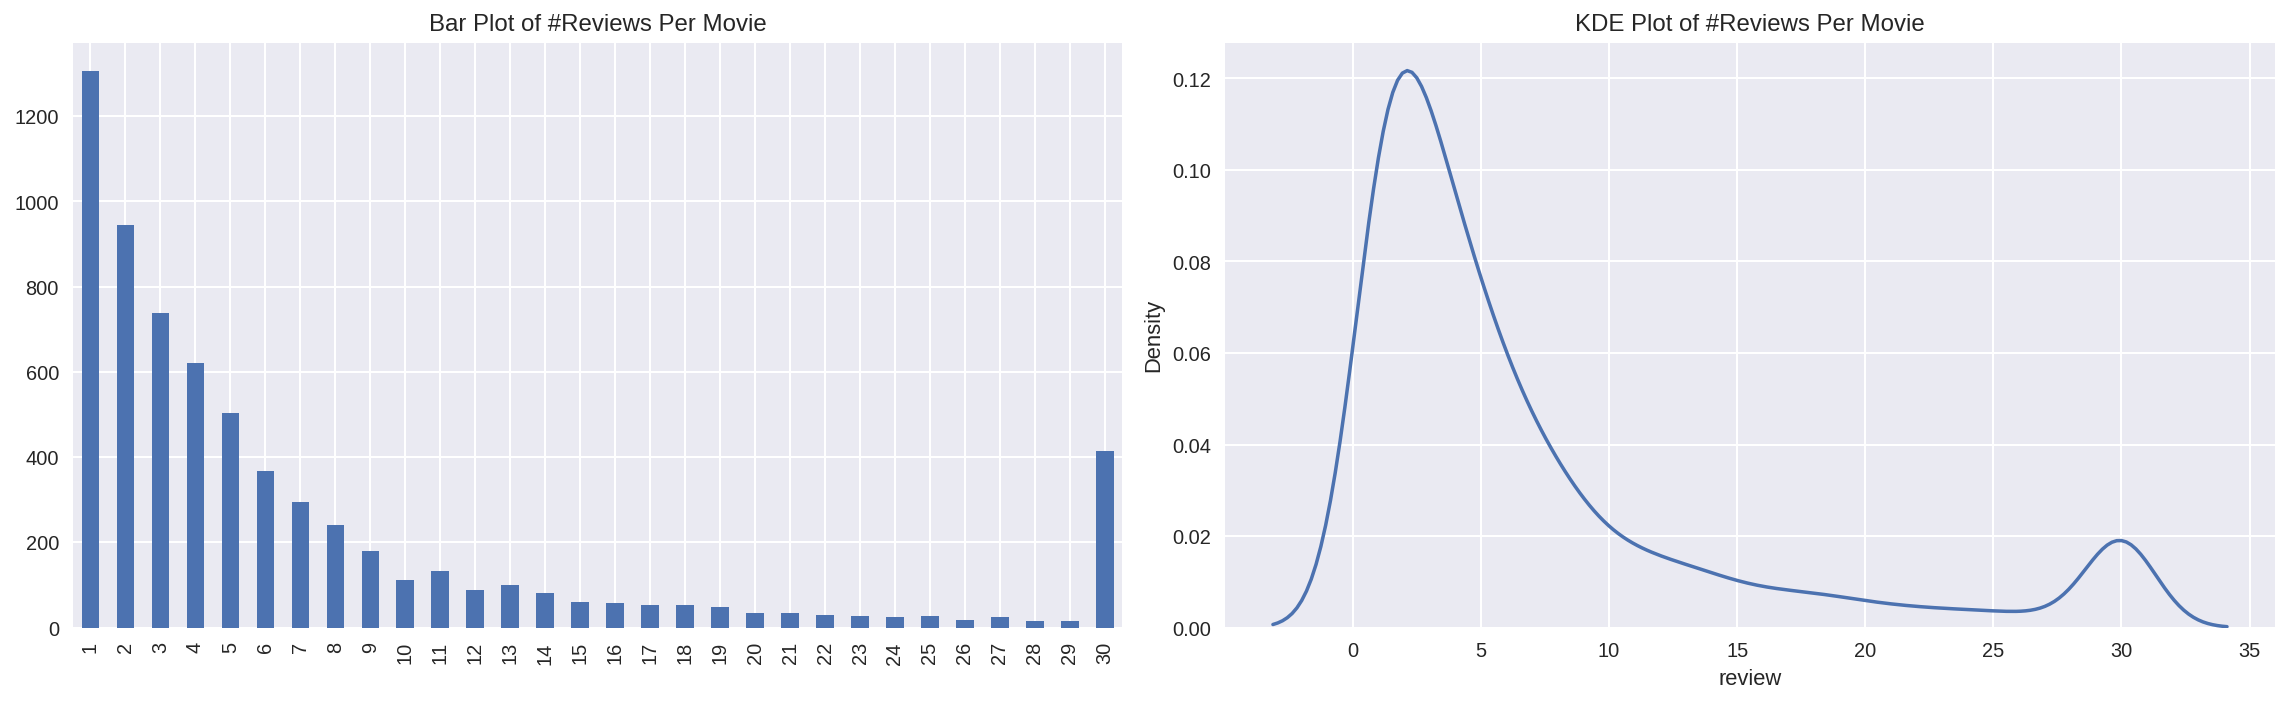

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

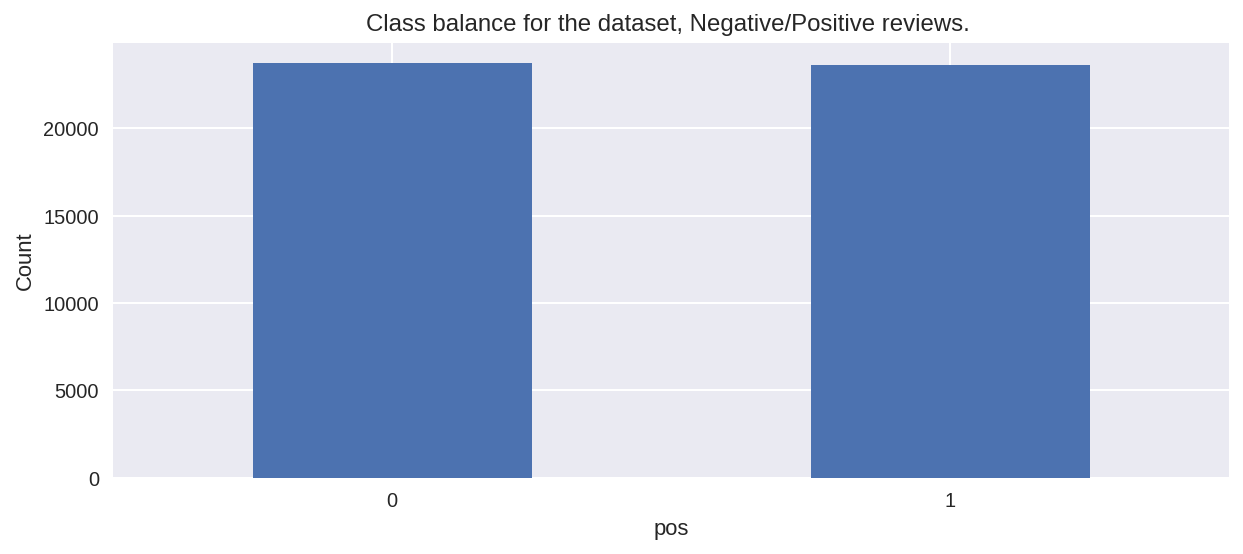

In [10]:
#PLOTTING THE TARGET.
count_target = pd.value_counts(df_reviews.pos, sort=True)
plt.figure(figsize=(10,4))
count_target.plot(kind='bar', rot=0)
plt.title('Class balance for the dataset, Negative/Positive reviews. ')
plt.xlabel('pos')
plt.ylabel('Count')
plt.show()

In [11]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

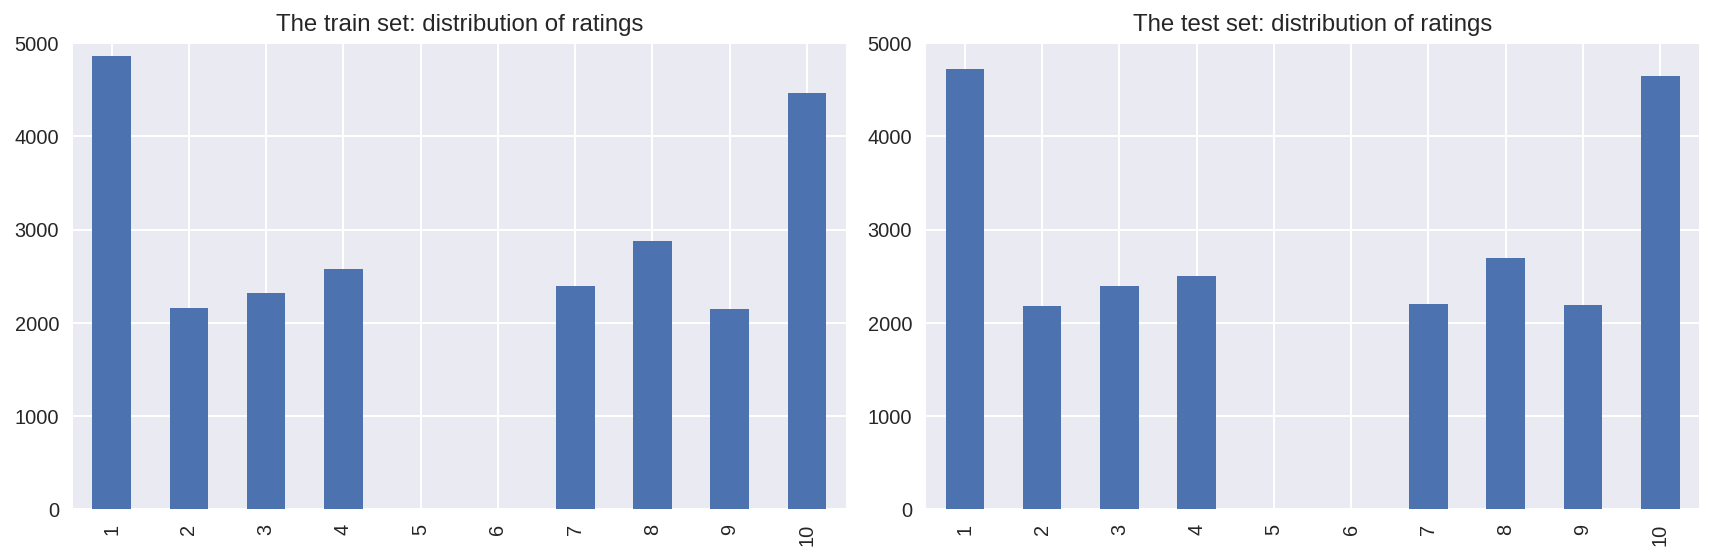

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

In [13]:

train_rating = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
print('Training set:', train_rating)

test_rating = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
print('Testing set:', test_rating)


Training set: 1     4863
2     2155
3     2317
4     2577
7     2393
8     2876
9     2153
10    4462
Name: rating, dtype: int64
Testing set: 1     4726
2     2184
3     2392
4     2501
7     2200
8     2700
9     2190
10    4642
Name: rating, dtype: int64


Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


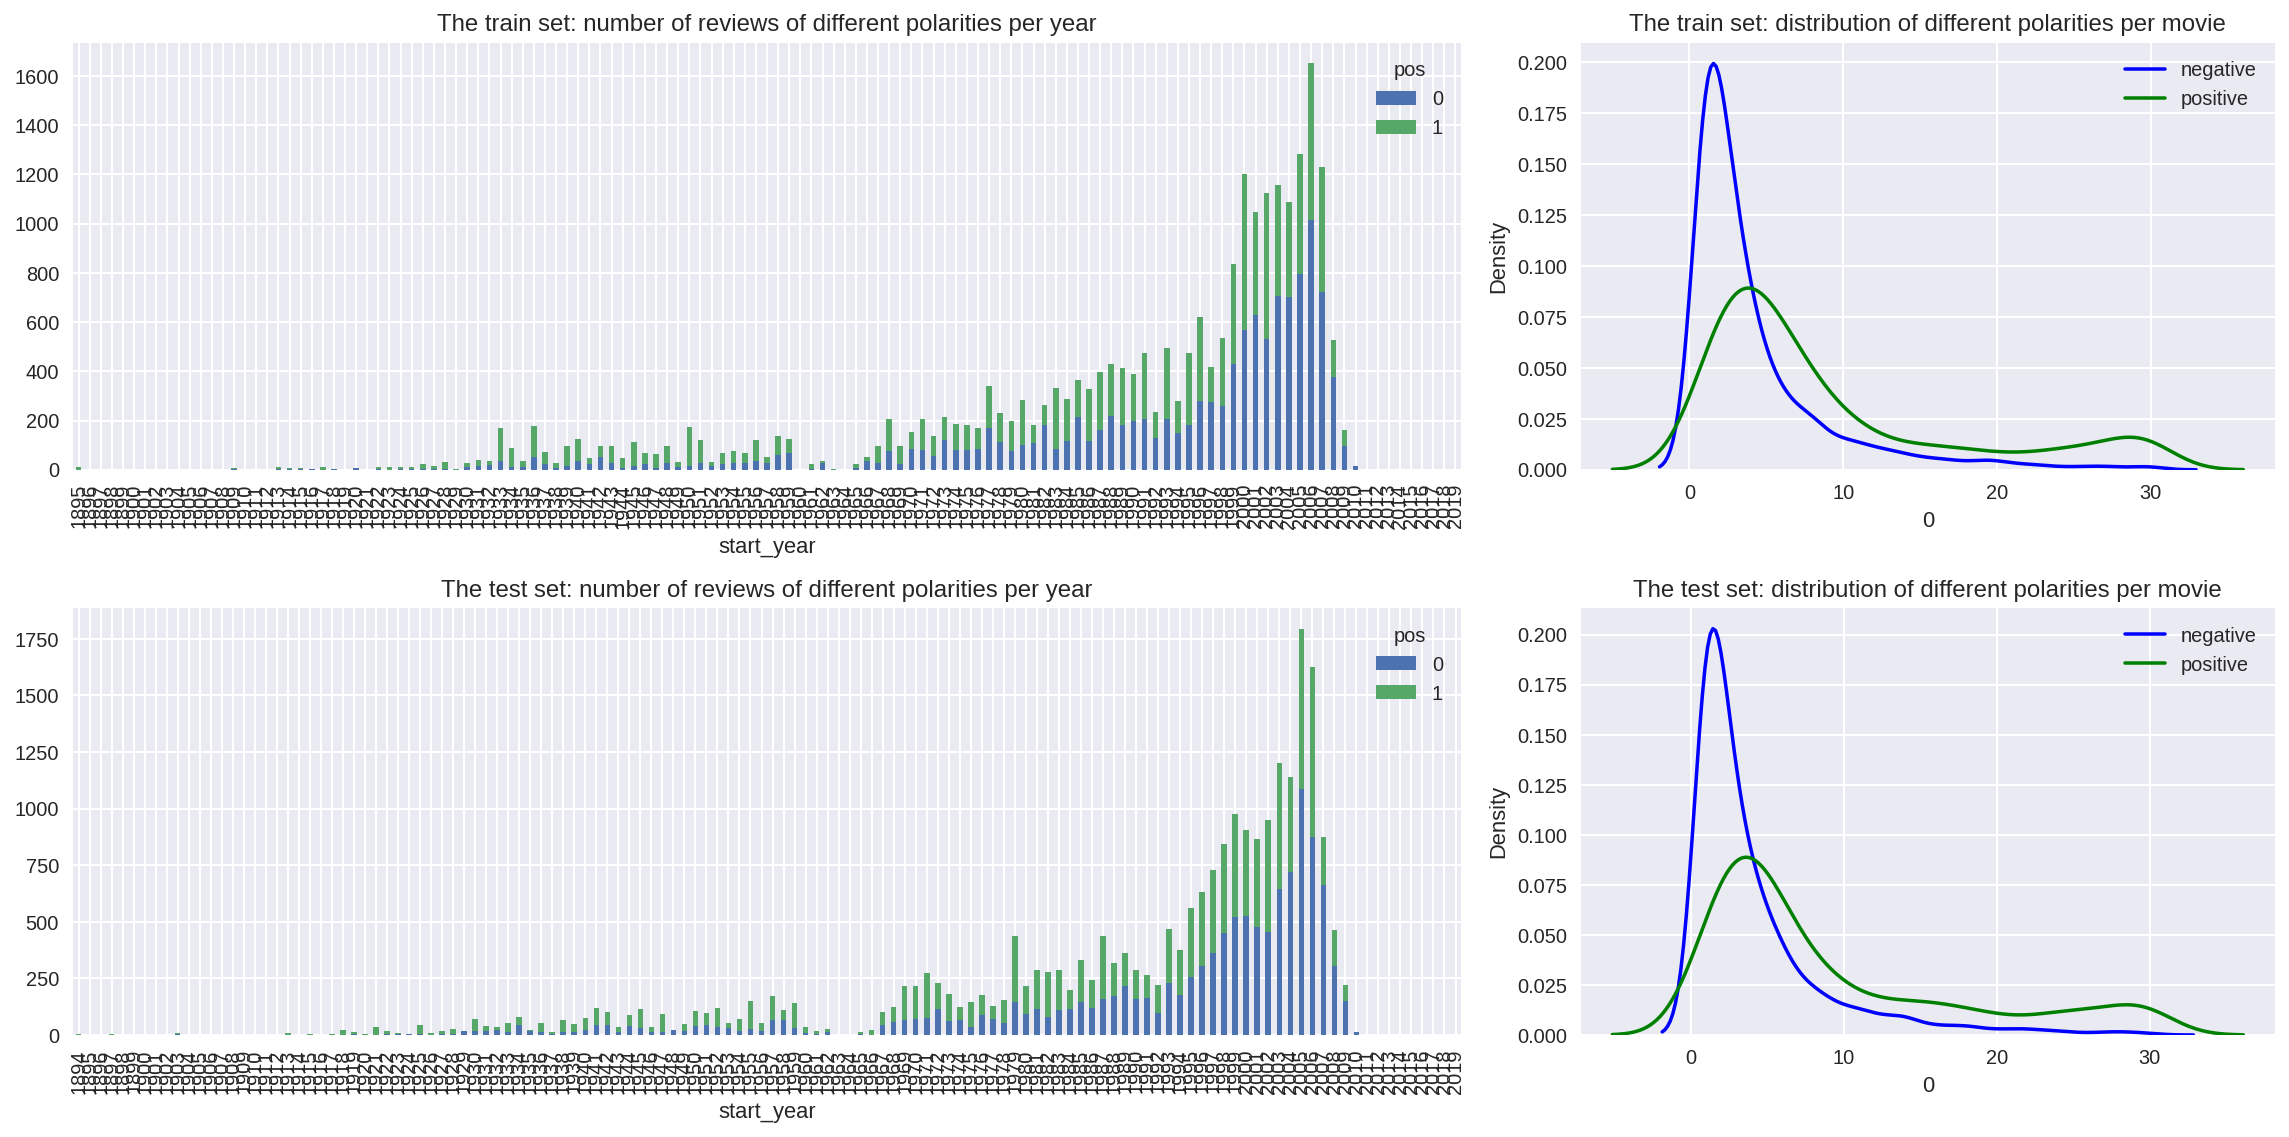

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [15]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [16]:
import re

# Convert to lowercase
df_reviews['review_norm'] = df_reviews['review'].str.lower()

# Using a lambda function with re.sub to remove any characters that are not lowercase letters or spaces
df_reviews['review_norm'] = df_reviews['review_norm'].apply(lambda x: re.sub(r'[^a-z ]', '', x))



## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder

In [19]:
#Creating encoded dataset.
encoder = LabelEncoder()
df_ordinal = df_reviews.copy()
df_ordinal['title_type'] = encoder.fit_transform(df_ordinal['title_type'])
df_ordinal['primary_title'] = encoder.fit_transform(df_ordinal['primary_title'])
df_ordinal['title_type'] = encoder.fit_transform(df_ordinal['title_type'])
df_ordinal['primary_title'] = encoder.fit_transform(df_ordinal['primary_title'])
df_ordinal['original_title'] = encoder.fit_transform(df_ordinal['original_title'])
df_ordinal['end_year'] = encoder.fit_transform(df_ordinal['end_year'])
df_ordinal['genres'] = encoder.fit_transform(df_ordinal['genres'])
df_ordinal['review'] = encoder.fit_transform(df_ordinal['review'])
df_ordinal['sp'] = encoder.fit_transform(df_ordinal['sp'])
df_ordinal['ds_part'] = encoder.fit_transform(df_ordinal['ds_part'])
df_ordinal['tconst'] = encoder.fit_transform(df_ordinal['tconst'])
display(df_ordinal)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,1191,0,0,0,1971,59,121,0,263,6.3,2218,33652,1,0,0,1,8335,the pakage implies that warren beatty and gold...
1,1191,0,0,0,1971,59,121,0,263,6.3,2218,11555,1,0,0,1,8336,how the hell did they get this made presenting...
2,4786,1,1,1,2002,59,25,0,288,6.3,184,34658,3,0,0,0,2489,there is no real story the film seems more lik...
3,4786,1,1,1,2002,59,25,0,288,6.3,184,42193,7,1,1,0,9280,um a serious film about troubled teens in sin...
4,4786,1,1,1,2002,59,25,0,288,6.3,184,20698,9,1,1,0,9281,im totally agree with garryjohal from singapor...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,1209,2,6553,6559,1972,59,97,0,369,7.7,2254,37362,10,1,1,0,6038,this is another of my favorite columbos it spo...
47327,4104,4,6554,6560,1996,59,55,0,197,7.3,278,31380,4,0,0,0,989,talk about being boring i got this expecting a...
47328,4104,4,6554,6560,1996,59,55,0,197,7.3,278,16363,8,1,1,0,4163,i never thought id say this about a biopic but...
47329,4104,4,6554,6560,1996,59,55,0,197,7.3,278,30787,9,1,1,0,4164,spirit and chaos is an artistic biopic of miya...


In [20]:
df_train_ordinal = df_ordinal[df_ordinal['ds_part'] == 1]
df_test_ordinal = df_ordinal[df_ordinal['ds_part'] == 0]

train_target_ordinal = df_train_ordinal['pos']
test_target_ordinal = df_test_ordinal['pos']

features_train_ordinal = df_train_ordinal.drop(['pos', 'review_norm'], axis=1)
features_test_ordinal = df_test_ordinal.drop(['pos', 'review_norm'], axis=1)

In [21]:
print(df_train_ordinal.shape)

(23796, 18)


In [22]:
model_0 = DummyClassifier()
model_0.fit(features_train_ordinal, train_target_ordinal)
predictions = model_0.predict(features_test_ordinal)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


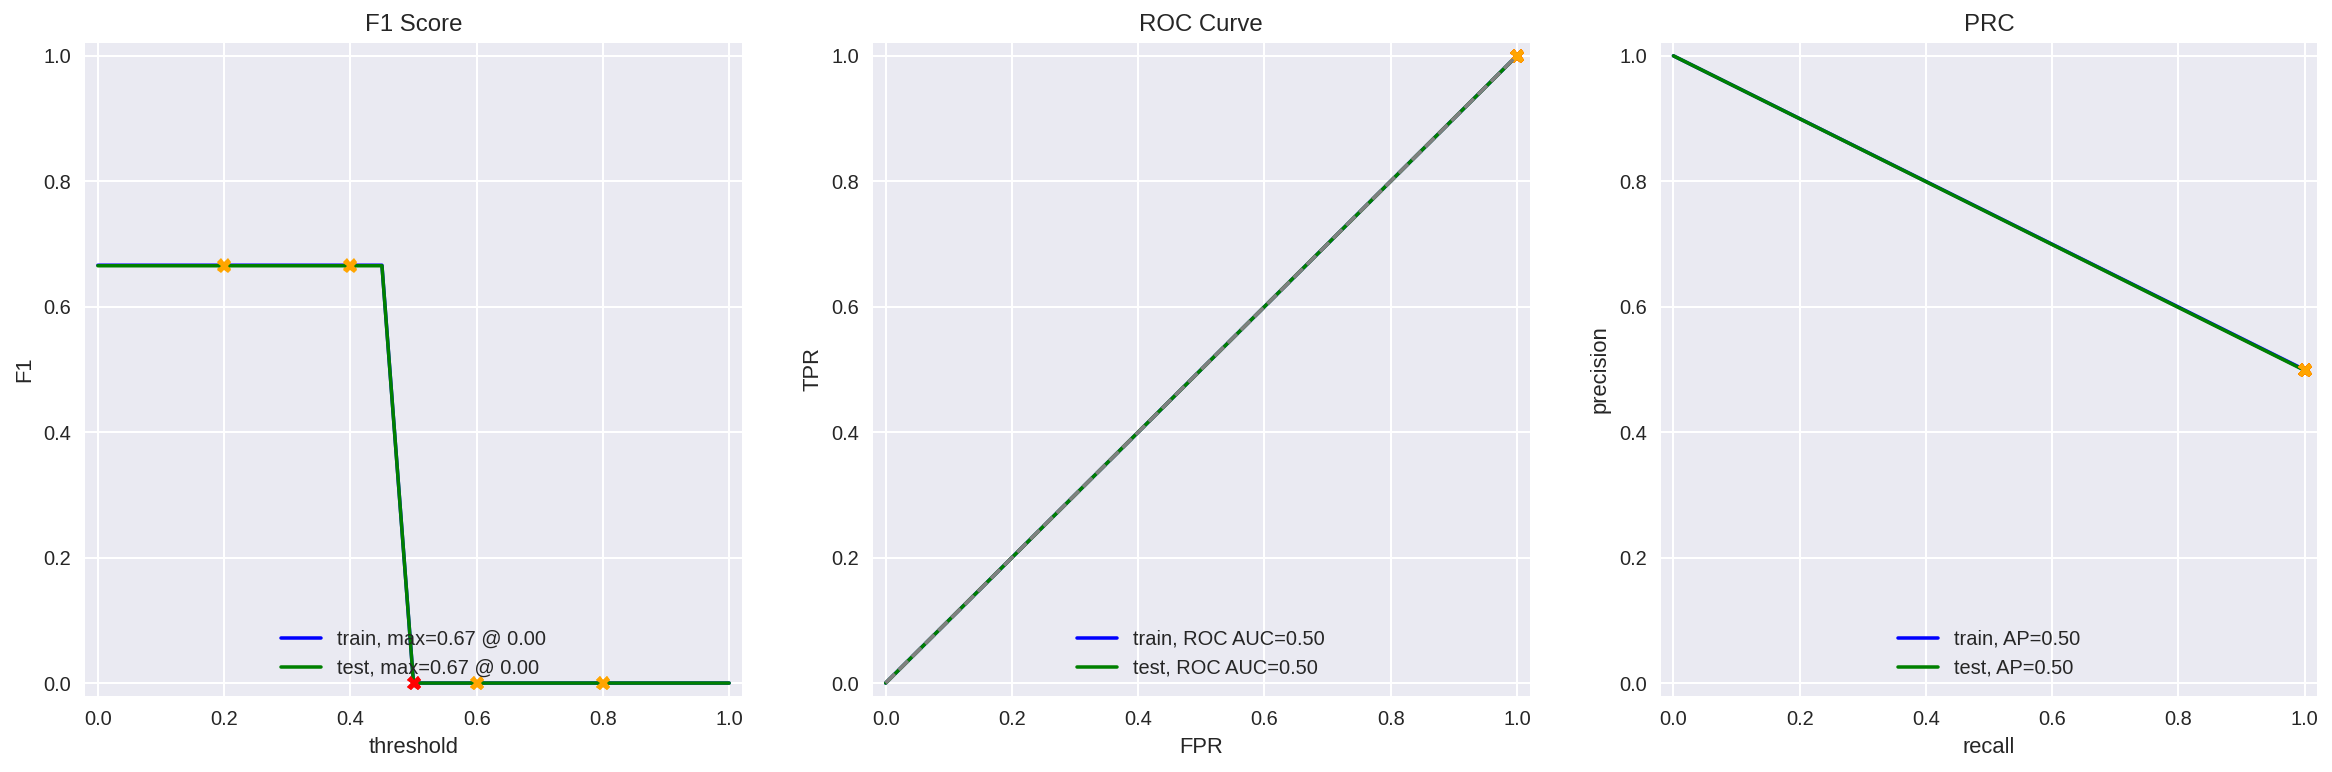

In [23]:
evaluate_model(model_0, features_train_ordinal, train_target_ordinal, features_test_ordinal, test_target_ordinal)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [24]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [25]:
nltk_train = df_reviews_train['review_norm']
nltk_test = df_reviews_test['review_norm']

stop_words = set(stopwords.words('english'))
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words) 
train_features_1 =  tfidf_vectorizer_2.fit_transform(nltk_train)
display(train_features_1)

<23796x105650 sparse matrix of type '<class 'numpy.float64'>'
	with 2377024 stored elements in Compressed Sparse Row format>

In [26]:
model_1 = LogisticRegression(solver='lbfgs')
model_1.fit(train_features_1, train_target)

test_features_1 =  tfidf_vectorizer_2.transform(nltk_test)
predictions = model_1.predict(test_features_1)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


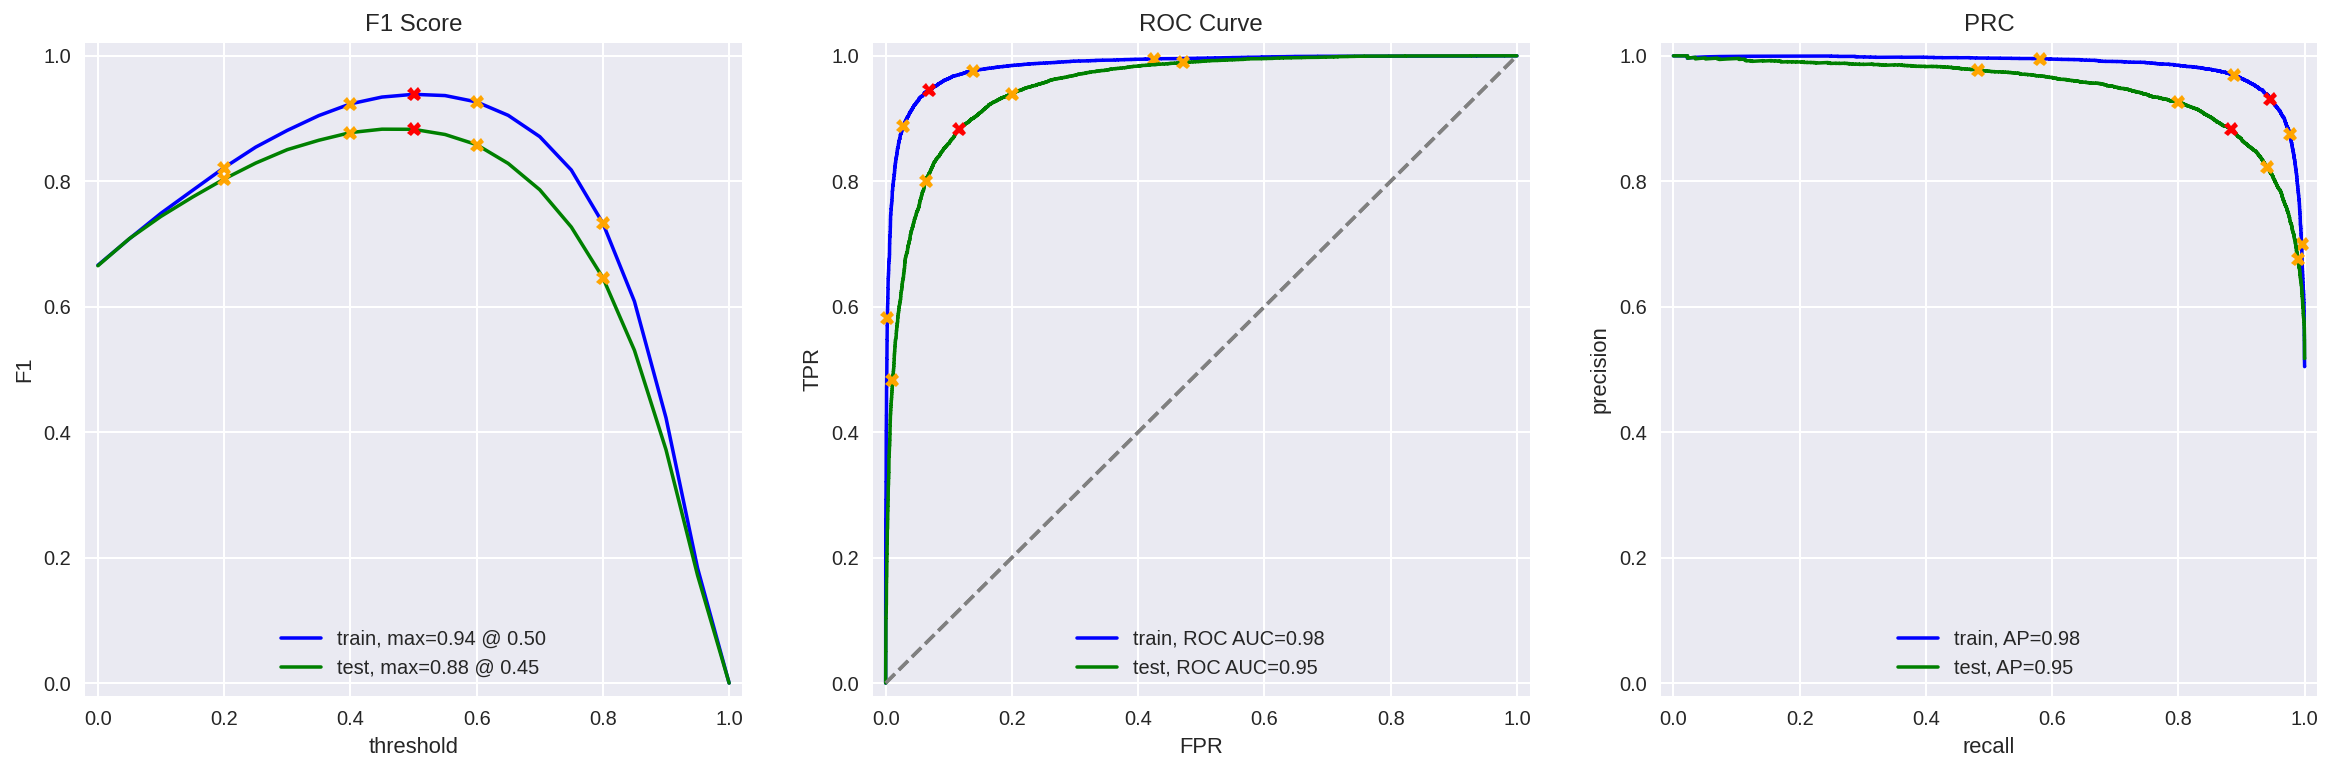

In [27]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [28]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [29]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [30]:
df_reviews['review_lemm'] = df_reviews['review_norm'].apply(text_preprocessing_3)

In [39]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

corpus_train = df_reviews_train['review_lemm']
corpus_test = df_reviews_test['review_lemm']

stop_words = set(stopwords.words('english'))
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words) 
train_features_2 =  tfidf_vectorizer_3.fit_transform(corpus_train)
display(train_features_2)

<23796x91284 sparse matrix of type '<class 'numpy.float64'>'
	with 2219918 stored elements in Compressed Sparse Row format>

In [40]:
model_2 = LogisticRegression(solver='lbfgs')
model_2.fit(train_features_2, train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


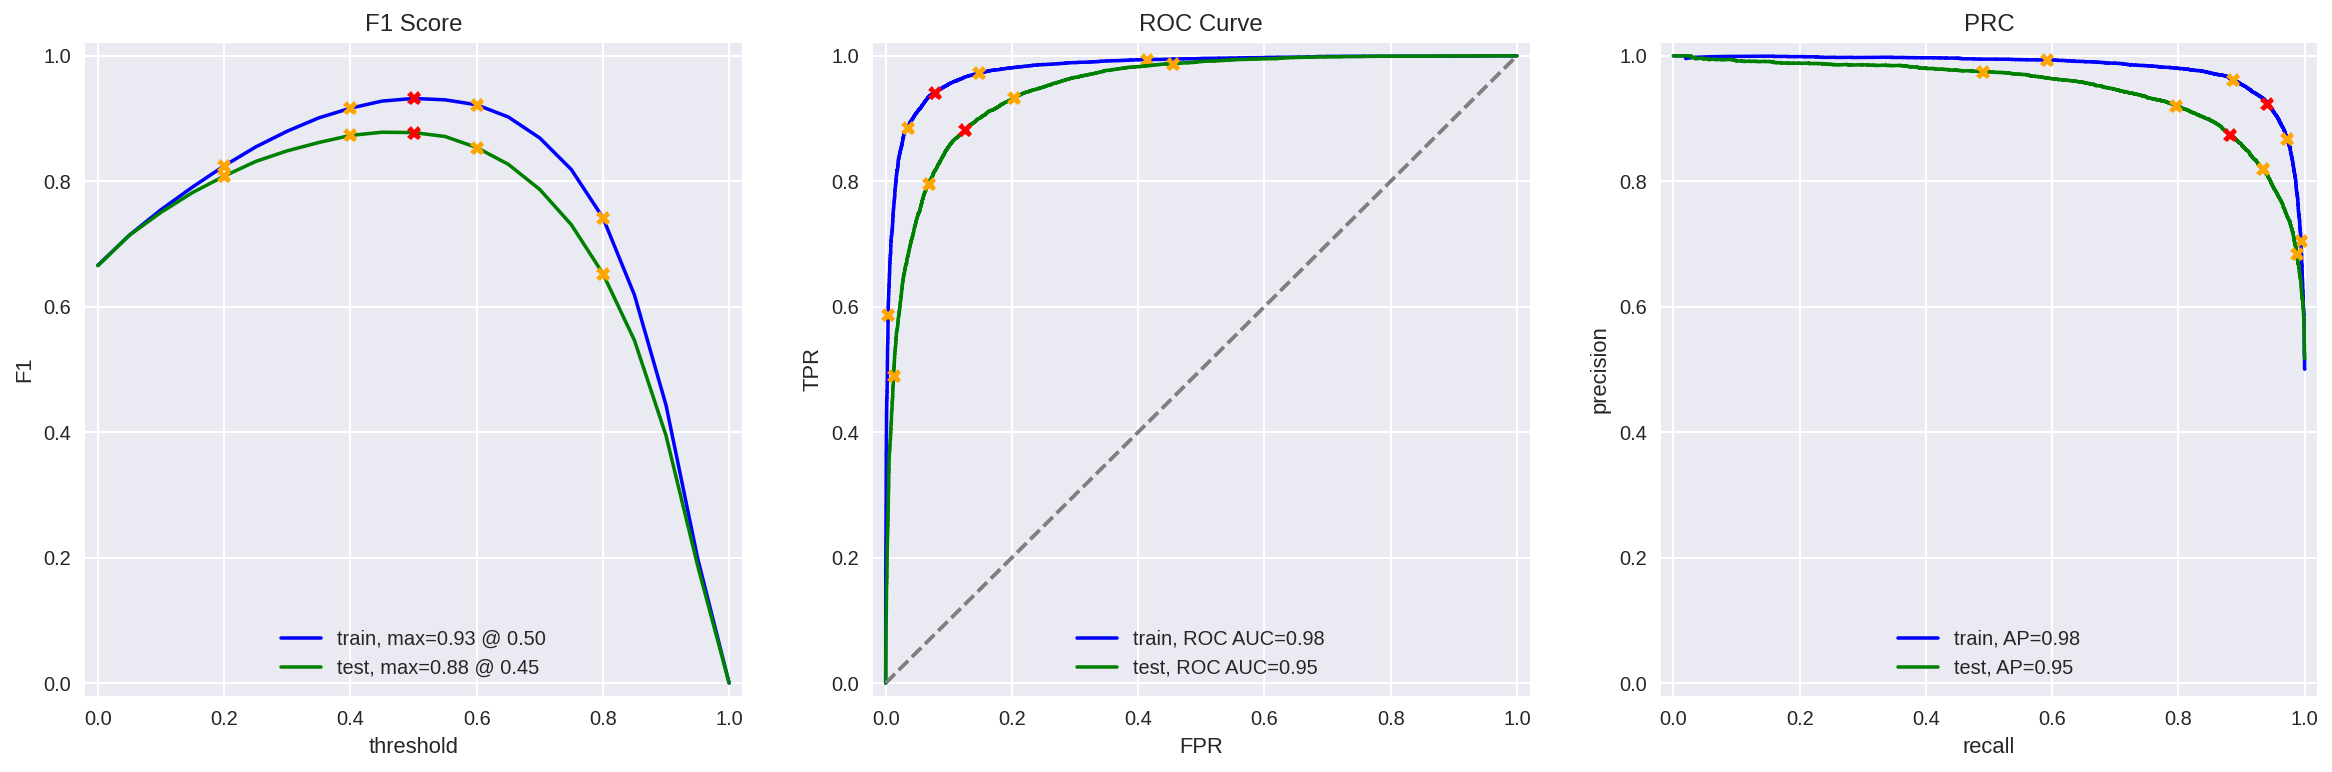

In [41]:
test_features_2 =  tfidf_vectorizer_3.transform(corpus_test)
predictions = model_2.predict(test_features_2)
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [42]:
from lightgbm import LGBMClassifier

In [43]:
stop_words = set(stopwords.words('english'))
tfidf_vectorizer_4 = TfidfVectorizer(stop_words=stop_words) 
train_features_3 =  tfidf_vectorizer_4.fit_transform(corpus_train)
display(train_features_3)

<23796x91284 sparse matrix of type '<class 'numpy.float64'>'
	with 2219918 stored elements in Compressed Sparse Row format>

In [45]:
model_3 = LGBMClassifier()
model_3.fit(train_features_3, train_target)
test_features_3 =  tfidf_vectorizer_4.transform(corpus_test)
predictions = model_3.predict(test_features_3)

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


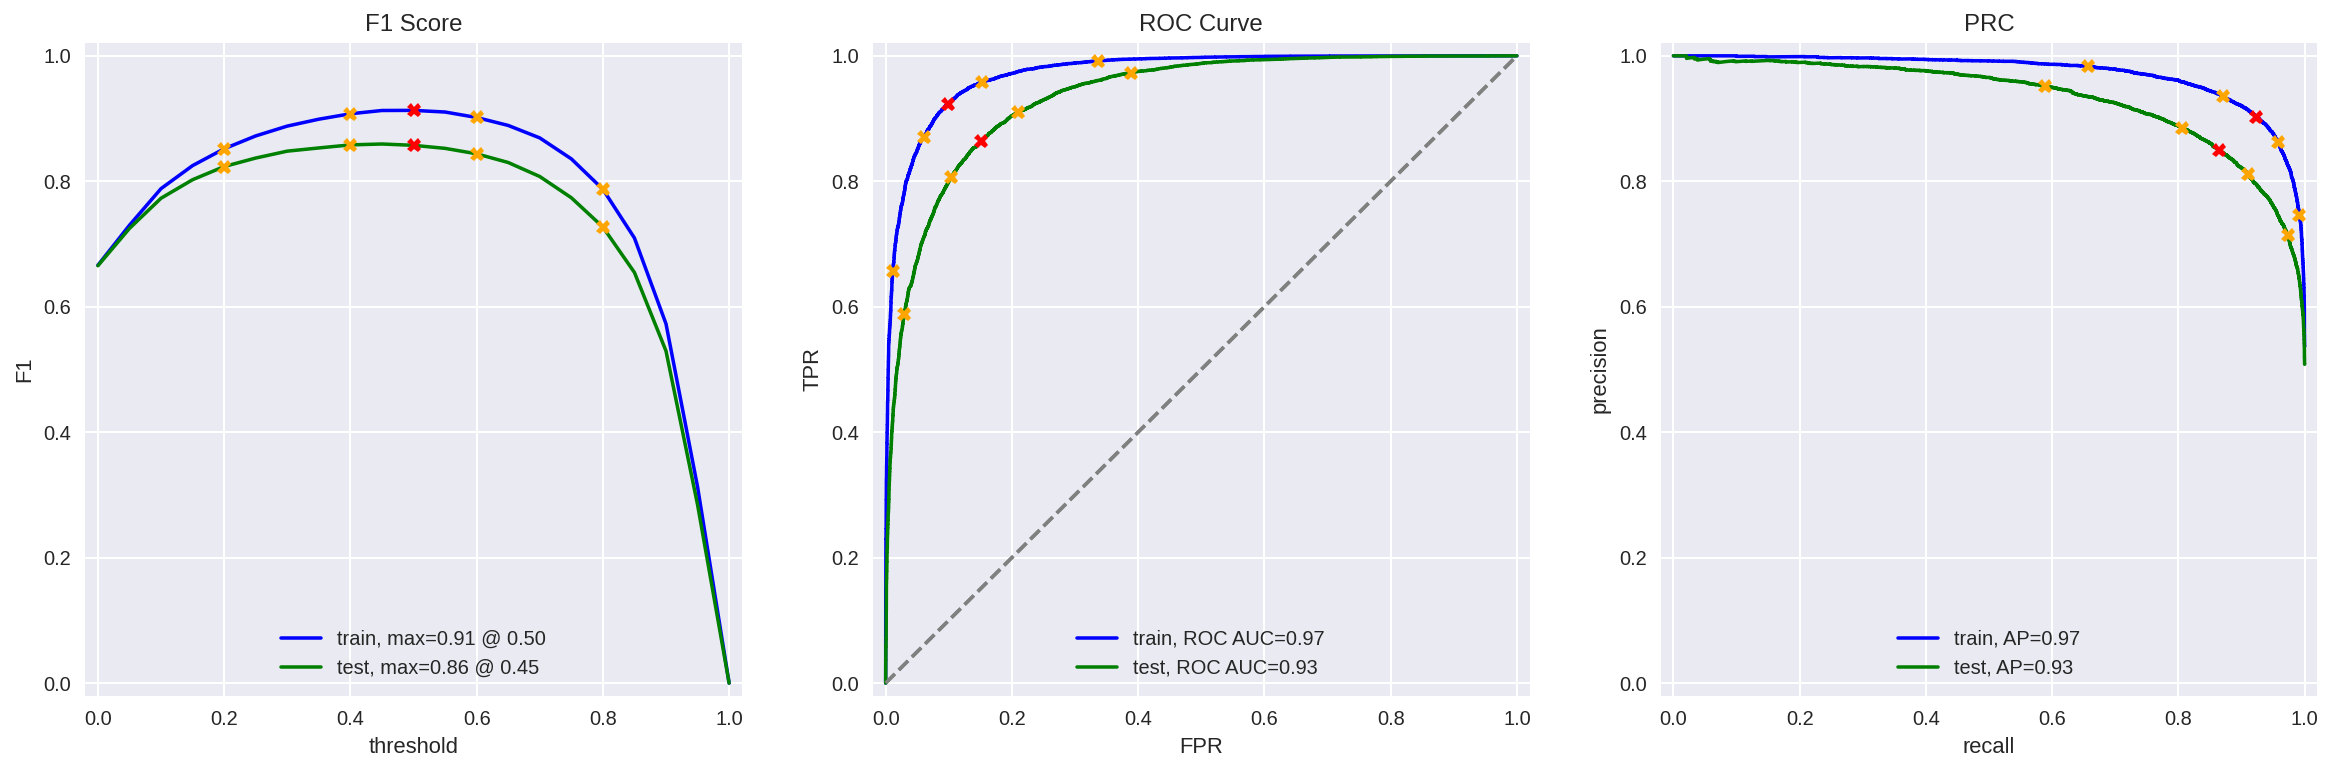

In [46]:
test_features_3 =  tfidf_vectorizer_4.transform(corpus_test)
predictions = model_3.predict(test_features_3)
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

###  Model 9 - BERT

In [47]:
import torch
import transformers

In [48]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [62]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [64]:
#print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(train_target.shape)

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [65]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.lower()

my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x: re.sub(r'[^a-z ]', '', x))



### Model 2

In [69]:

corpus_test = my_reviews['review_norm']

stop_words = set(stopwords.words('english'))
tfidf_vectorizer_5 = TfidfVectorizer(stop_words=stop_words) 
train_features_5 =  tfidf_vectorizer_5.fit_transform(corpus_train)
display(train_features_5)

<23796x91284 sparse matrix of type '<class 'numpy.float64'>'
	with 2219918 stored elements in Compressed Sparse Row format>

In [71]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_5.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.33:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.47:  i didnt expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.94:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 3

In [72]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.60:  i did not simply like it not my kind of movie
0.34:  well i was bored and felt asleep in the middle of the movie
0.60:  i was really fascinated with the movie
0.37:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.64:  i didnt expect the reboot to be so good writers really cared about the source material
0.69:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.23:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.81:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 9

In [75]:
#texts = my_reviews['review_norm']

#my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

#my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

#for i, review in enumerate(texts.str.slice(0, 100)):
    #print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

<div class="alert alert-info">
  Upon loading data, I decided to minimally process the data since there were no duplicates and the 2 NaN, I dropped.  Within EDA I checked the 'pos' column balance which the classes were correctly balanced at nearly 50/50.

Started to buid models. The results coming from model buildings were:

*NLTK, TF-IDF and LR got F1 0.94 (train) 0.88 (test)<br>
*Spacy, TF-IDF and LR got F1 0.93 (train) 0.88 (test)<br>
*Spacy, TF-IDF and LGBM got F1 0.91 (train) 0.86 (test)<br>
*BERT I could not run because I used the online platform system to prevent known errors.<br>
*All outperforming the dummy model at random 50/50 <br>

The last reviews probabilities, the other models correctly classified the majority of my reviews, but they found difficulties while classifiyng false positive comments; sarcasm doesn't seem to be understood exponentially (but that's even amongst humans!). 
</div>

